<a href="https://colab.research.google.com/github/ronihs/DeepNeuralNet/blob/master/BBCA_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime import datetime, timedelta
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("=" * 60)
print("LSTM STOCK PRICE PREDICTION - BBCA")
print("=" * 60)

LSTM STOCK PRICE PREDICTION - BBCA


In [ ]:
# ==========================================
# 1. IMPORT DATA DARI YFINANCE
# ==========================================
print("\n[1] Mengambil data saham BBCA dari Yahoo Finance...")

ticker = "BBCA.JK"  # Kode saham BCA di Yahoo Finance
start_date = "2005-01-01"
end_date = "2025-12-31"

# Download data
df = yf.download(ticker, start=start_date, end=end_date, progress=False)

# Flatten columns jika multi-level (dari yfinance)
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)

print(f"✓ Data berhasil diambil: {len(df)} hari data")
print(df.head())
print(df.tail())
print(f"  Periode: {df.index[0].strftime('%Y-%m-%d')} hingga {df.index[-1].strftime('%Y-%m-%d')}")


[1] Mengambil data saham BBCA dari Yahoo Finance...
✓ Data berhasil diambil: 5162 hari data
Price            Close        High         Low        Open     Volume
Date                                                                 
2005-01-03  190.579208  190.579208  188.964130  190.579208  126180000
2005-01-04  193.809387  195.424465  190.579231  190.579231  291730000
2005-01-05  198.654556  203.499789  193.809323  193.809323  564730000
2005-01-06  198.654556  200.269634  195.424401  200.269634  161150000
2005-01-07  190.579208  197.039521  188.964130  197.039521  592910000
Price        Close    High     Low    Open     Volume
Date                                                 
2025-12-05  8300.0  8300.0  8200.0  8200.0   71162300
2025-12-08  8300.0  8350.0  8250.0  8350.0   61745200
2025-12-09  8100.0  8300.0  8100.0  8300.0  113057200
2025-12-10  8075.0  8175.0  8025.0  8100.0  143418300
2025-12-11  8000.0  8200.0  7900.0  8175.0  140766000
  Periode: 2005-01-03 hingga 2025-12-11


[2] Melakukan analisis data...

Statistik Deskriptif:
Price          Open          High           Low         Close        Volume
count   5162.000000   5162.000000   5162.000000   5162.000000  5.162000e+03
mean    3306.189626   3336.909019   3274.655733   3305.657602  1.023676e+08
std     2950.571607   2975.006374   2926.381818   2949.617965  1.131079e+08
min      179.273610    182.503765    176.043488    179.273636  0.000000e+00
25%      790.339355    805.538200    769.440977    790.339355  4.987012e+07
50%     2163.505062   2180.474389   2148.297083   2163.987061  7.320960e+07
75%     5464.860411   5501.302789   5405.795056   5456.195801  1.136456e+08
max    10453.046259  10500.997070  10333.171875  10500.997070  1.949960e+09

Missing values: 0
✓ Grafik analisis disimpan sebagai 'bbca_analysis.png'


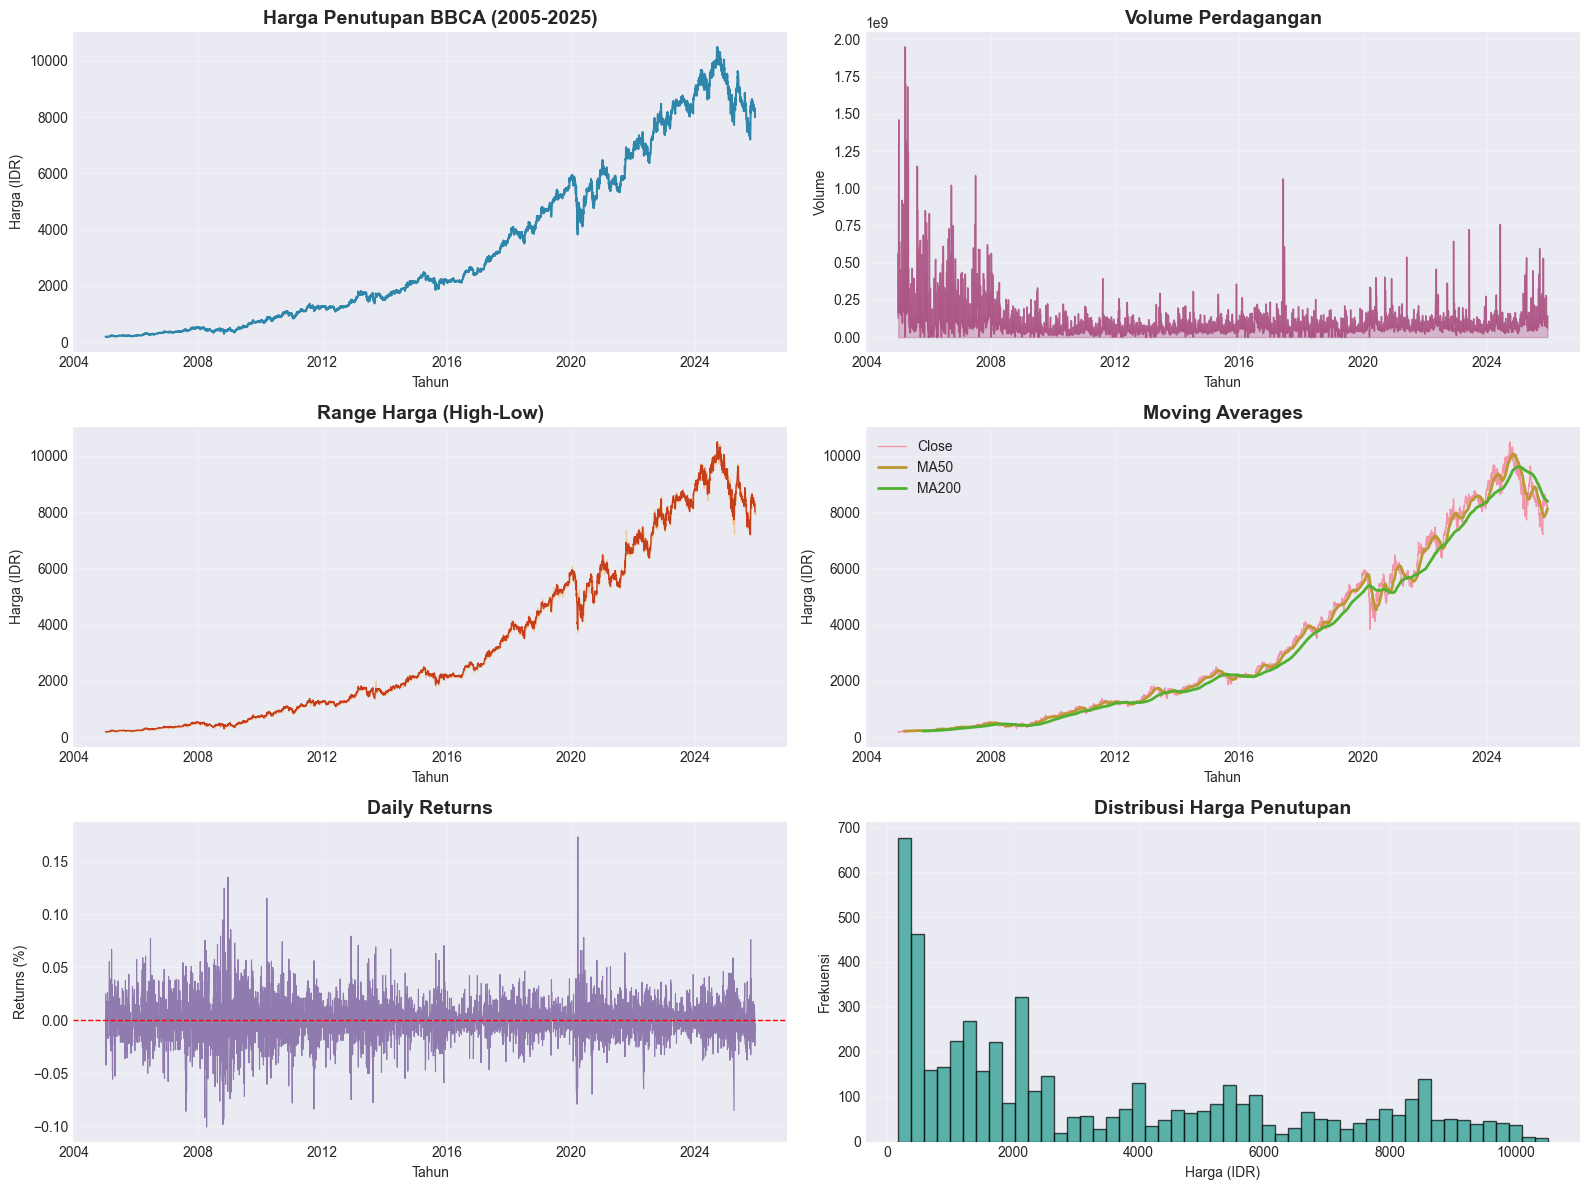

In [ ]:
# ==========================================
# 2. ANALISIS DATA & VISUALISASI
# ==========================================
print("\n[2] Melakukan analisis data...")

# Statistik deskriptif
print("\nStatistik Deskriptif:")
print(df[['Open', 'High', 'Low', 'Close', 'Volume']].describe())

# Cek missing values
print(f"\nMissing values: {df.isnull().sum().sum()}")

# Visualisasi data
fig = plt.figure(figsize=(16, 12))

# Plot 1: Harga Close
ax1 = plt.subplot(3, 2, 1)
plt.plot(df.index, df['Close'], linewidth=1.5, color='#2E86AB')
plt.title('Harga Penutupan BBCA (2005-2025)', fontsize=14, fontweight='bold')
plt.xlabel('Tahun')
plt.ylabel('Harga (IDR)')
plt.grid(True, alpha=0.3)

# Plot 2: Volume perdagangan
ax2 = plt.subplot(3, 2, 2)
volume_data = df['Volume'].values.flatten()
plt.plot(df.index, volume_data, color='#A23B72', alpha=0.7, linewidth=1)
plt.fill_between(df.index, 0, volume_data, color='#A23B72', alpha=0.3)
plt.title('Volume Perdagangan', fontsize=14, fontweight='bold')
plt.xlabel('Tahun')
plt.ylabel('Volume')
plt.grid(True, alpha=0.3)

# Plot 3: Candlestick simplified (High-Low range)
ax3 = plt.subplot(3, 2, 3)
plt.fill_between(df.index, df['Low'], df['High'], alpha=0.3, color='#F18F01')
plt.plot(df.index, df['Close'], linewidth=1, color='#C73E1D')
plt.title('Range Harga (High-Low)', fontsize=14, fontweight='bold')
plt.xlabel('Tahun')
plt.ylabel('Harga (IDR)')
plt.grid(True, alpha=0.3)

# Plot 4: Moving averages
ax4 = plt.subplot(3, 2, 4)
df['MA50'] = df['Close'].rolling(window=50).mean()
df['MA200'] = df['Close'].rolling(window=200).mean()
plt.plot(df.index, df['Close'], label='Close', linewidth=1, alpha=0.7)
plt.plot(df.index, df['MA50'], label='MA50', linewidth=2)
plt.plot(df.index, df['MA200'], label='MA200', linewidth=2)
plt.title('Moving Averages', fontsize=14, fontweight='bold')
plt.xlabel('Tahun')
plt.ylabel('Harga (IDR)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 5: Daily returns
ax5 = plt.subplot(3, 2, 5)
df['Returns'] = df['Close'].pct_change()
plt.plot(df.index, df['Returns'], linewidth=0.8, color='#6A4C93', alpha=0.7)
plt.title('Daily Returns', fontsize=14, fontweight='bold')
plt.xlabel('Tahun')
plt.ylabel('Returns (%)')
plt.axhline(y=0, color='r', linestyle='--', linewidth=1)
plt.grid(True, alpha=0.3)

# Plot 6: Distribusi harga
ax6 = plt.subplot(3, 2, 6)
plt.hist(df['Close'], bins=50, color='#1B998B', alpha=0.7, edgecolor='black')
plt.title('Distribusi Harga Penutupan', fontsize=14, fontweight='bold')
plt.xlabel('Harga (IDR)')
plt.ylabel('Frekuensi')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('bbca_analysis.png', dpi=300, bbox_inches='tight')
print("✓ Grafik analisis disimpan sebagai 'bbca_analysis.png'")

In [ ]:
# ==========================================
# 3. PERSIAPAN DATASET & DATALOADER
# ==========================================
print("\n[3] Mempersiapkan dataset...")

# Gunakan hanya kolom Close untuk prediksi
data = df['Close'].values.reshape(-1, 1)

# Normalisasi data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Parameter
sequence_length = 60  # Gunakan 60 hari untuk prediksi hari berikutnya
train_size = int(len(scaled_data) * 0.8)

# Split data
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size - sequence_length:]

# Buat sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

print(f"✓ Training set: {X_train.shape}")
print(f"✓ Testing set: {X_test.shape}")

# Custom Dataset
class StockDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# DataLoader
batch_size = 32
train_dataset = StockDataset(X_train, y_train)
test_dataset = StockDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"✓ DataLoader dibuat dengan batch size: {batch_size}")


[3] Mempersiapkan dataset...
✓ Training set: (4069, 60, 1)
✓ Testing set: (1033, 60, 1)
✓ DataLoader dibuat dengan batch size: 32


In [ ]:
# ==========================================
# 4. ARSITEKTUR LSTM
# ==========================================
print("\n[4] Membangun arsitektur LSTM...")

class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=128, num_layers=2, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # LSTM layers
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout,
            batch_first=True
        )

        # Fully connected layers
        self.fc1 = nn.Linear(hidden_size, 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        # LSTM forward
        lstm_out, _ = self.lstm(x)

        # Ambil output dari timestep terakhir
        last_output = lstm_out[:, -1, :]

        # Fully connected layers
        out = self.fc1(last_output)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)

        return out

# Inisialisasi model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTMModel(input_size=1, hidden_size=128, num_layers=2, dropout=0.2).to(device)

print(f"✓ Model dibuat dan dipindahkan ke: {device}")
print(f"\nArsitektur Model:")
print(model)


[4] Membangun arsitektur LSTM...
✓ Model dibuat dan dipindahkan ke: cpu

Arsitektur Model:
LSTMModel(
  (lstm): LSTM(1, 128, num_layers=2, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)



[5] Melatih model...


Epoch 1/10 [Train]:  30%|████████                   | 38/128 [00:10<00:21,  4.12it/s, loss=0.009159]


Epoch 1/10 [Train]:  60%|████████████████▏          | 77/128 [00:19<00:12,  4.07it/s, loss=0.002176]


Epoch 1/10 [Train]:  91%|███████████████████████▌  | 116/128 [00:29<00:02,  4.17it/s, loss=0.002696]


Epoch 1/10 [Train]:  99%|█████████████████████████▊| 127/128 [00:32<00:00,  3.94it/s, loss=0.005354]
                                                                                                    
Epoch 1/10 [Test]:  97%|████████████████████████████ | 32/33 [00:03<00:00, 10.53it/s, loss=0.000813]
Training Progress:  10%| | 1/10 [00:35<05:16, 35.19s/it, Train Loss=0.013366, Test Loss=0.002344, Be
Epoch 2/10 [Train]:   1%|▏                           | 1/128 [00:00<00:29,  4.31it/s, loss=0.000672]


Epoch 2/10 [Train]:  31%|████████▍                  | 40/128 [00:10<00:24,  3.58it/s, loss=0.001356]


Epoch 2/10 [Train]:  62%|████████████████▋          | 79/128 [00:23<00:40,  1.21it/s, loss=0.000976]


Epoch 2/10 [Train]:  92%|███████████████████████▉  | 118/128 [00:34<00:03,  2.79it/s, loss=0.000802]


Epoch 2/10 [Train]: 100%|██████████████████████████| 128/128 [00:37<00:00,  4.06it/s, loss=0.000177]
                                                                                                    
Epoch 2/10 [Test]: 100%|█████████████████████████████| 33/33 [00:02<00:00, 12.44it/s, loss=0.009649]
Training Progress:  20%|▏| 2/10 [01:15<05:07, 38.47s/it, Train Loss=0.001295, Test Loss=0.012973, Be
Epoch 3/10 [Train]:   1%|▏                           | 1/128 [00:00<00:27,  4.54it/s, loss=0.001159]


Epoch 3/10 [Train]:  31%|████████▍                  | 40/128 [00:15<00:26,  3.33it/s, loss=0.002032]


Epoch 3/10 [Train]:  62%|████████████████▋          | 79/128 [00:25<00:12,  3.90it/s, loss=0.001702]


Epoch 3/10 [Train]:  92%|███████████████████████▉  | 118/128 [00:36<00:03,  3.26it/s, loss=0.001716]


Epoch 3/10 [Train]:  99%|█████████████████████████▊| 127/128 [00:38<00:00,  3.96it/s, loss=0.000742]
                                                                                                    
Epoch 3/10 [Test]:  97%|████████████████████████████ | 32/33 [00:03<00:00,  9.78it/s, loss=0.003657]
Training Progress:  30%|▎| 3/10 [01:57<04:39, 39.89s/it, Train Loss=0.001060, Test Loss=0.006022, Be
Epoch 4/10 [Train]:   1%|▏                           | 1/128 [00:00<00:31,  4.03it/s, loss=0.001239]


Epoch 4/10 [Train]:  31%|████████▍                  | 40/128 [00:10<00:21,  4.11it/s, loss=0.001087]


Epoch 4/10 [Train]:  62%|████████████████▋          | 79/128 [00:21<00:12,  3.95it/s, loss=0.001334]


Epoch 4/10 [Train]:  92%|███████████████████████▉  | 118/128 [00:31<00:02,  3.83it/s, loss=0.001792]


Epoch 4/10 [Train]:  99%|█████████████████████████▊| 127/128 [00:33<00:00,  3.81it/s, loss=0.002214]
                                                                                                    
Epoch 4/10 [Test]: 100%|█████████████████████████████| 33/33 [00:03<00:00, 10.43it/s, loss=0.004271]
Training Progress:  40%|▍| 4/10 [02:34<03:52, 38.79s/it, Train Loss=0.000968, Test Loss=0.006766, Be
Epoch 5/10 [Train]:   2%|▍                           | 2/128 [00:00<00:36,  3.49it/s, loss=0.000769]


Epoch 5/10 [Train]:  32%|████████▋                  | 41/128 [00:11<00:24,  3.60it/s, loss=0.001081]


Epoch 5/10 [Train]:  62%|████████████████▉          | 80/128 [00:23<00:14,  3.30it/s, loss=0.000789]


Epoch 5/10 [Train]:  93%|████████████████████████▏ | 119/128 [00:35<00:02,  3.20it/s, loss=0.001478]


Epoch 5/10 [Train]: 100%|██████████████████████████| 128/128 [00:37<00:00,  4.05it/s, loss=0.000081]
                                                                                                    
Epoch 5/10 [Test]:  91%|██████████████████████████▎  | 30/33 [00:03<00:00,  9.22it/s, loss=0.005041]


Epoch 5/10 [Test]:  97%|████████████████████████████ | 32/33 [00:03<00:00,  9.06it/s, loss=0.003613]
Training Progress:  50%|▌| 5/10 [03:15<03:18, 39.66s/it, Train Loss=0.000922, Test Loss=0.005953, Be
Epoch 6/10 [Train]:  28%|███████▌                   | 36/128 [00:12<00:42,  2.14it/s, loss=0.000826]


Epoch 6/10 [Train]:  59%|███████████████▊           | 75/128 [00:26<00:13,  4.00it/s, loss=0.001042]


Epoch 6/10 [Train]:  89%|███████████████████████▏  | 114/128 [00:37<00:03,  3.93it/s, loss=0.001622]


Epoch 6/10 [Train]:  99%|█████████████████████████▊| 127/128 [00:40<00:00,  3.98it/s, loss=0.000394]
                                                                                                    
Epoch 6/10 [Test]:  82%|███████████████████████▋     | 27/33 [00:02<00:00,  8.83it/s, loss=0.001159]


Epoch 6/10 [Test]:  97%|████████████████████████████ | 32/33 [00:03<00:00,  8.52it/s, loss=0.000646]
Training Progress:  60%|▌| 6/10 [04:00<02:44, 41.19s/it, Train Loss=0.000902, Test Loss=0.002107, Be
Epoch 7/10 [Train]:  25%|██████▊                    | 32/128 [00:09<00:24,  3.90it/s, loss=0.000942]


Epoch 7/10 [Train]:  55%|██████████████▉            | 71/128 [00:19<00:15,  3.69it/s, loss=0.000916]


Epoch 7/10 [Train]:  86%|██████████████████████▎   | 110/128 [00:34<00:07,  2.53it/s, loss=0.000622]


Epoch 7/10 [Train]:  99%|█████████████████████████▊| 127/128 [00:40<00:00,  2.66it/s, loss=0.000442]
                                                                                                    
Epoch 7/10 [Test]:  76%|█████████████████████▉       | 25/33 [00:02<00:00,  9.98it/s, loss=0.000840]


Epoch 7/10 [Test]:  97%|████████████████████████████ | 32/33 [00:03<00:00,  9.81it/s, loss=0.000341]
Training Progress:  70%|▋| 7/10 [04:43<02:06, 42.01s/it, Train Loss=0.000802, Test Loss=0.001620, Be
Epoch 8/10 [Train]:  26%|██████▉                    | 33/128 [00:08<00:23,  4.00it/s, loss=0.000501]


Epoch 8/10 [Train]:  56%|███████████████▏           | 72/128 [00:18<00:13,  4.00it/s, loss=0.000520]


Epoch 8/10 [Train]:  87%|██████████████████████▌   | 111/128 [00:28<00:04,  4.22it/s, loss=0.000696]


Epoch 8/10 [Train]:  99%|█████████████████████████▊| 127/128 [00:32<00:00,  4.44it/s, loss=0.000267]
                                                                                                    
Epoch 8/10 [Test]:  79%|██████████████████████▊      | 26/33 [00:02<00:00,  9.73it/s, loss=0.002824]


Epoch 8/10 [Test]:  97%|████████████████████████████ | 32/33 [00:03<00:00,  9.66it/s, loss=0.002189]
Training Progress:  80%|▊| 8/10 [05:19<01:20, 40.12s/it, Train Loss=0.000837, Test Loss=0.004137, Be
Epoch 9/10 [Train]:  26%|██████▉                    | 33/128 [00:08<00:24,  3.88it/s, loss=0.000591]


Epoch 9/10 [Train]:  56%|███████████████▏           | 72/128 [00:17<00:13,  4.15it/s, loss=0.000968]


Epoch 9/10 [Train]:  87%|██████████████████████▌   | 111/128 [00:27<00:04,  4.22it/s, loss=0.000379]


Epoch 9/10 [Train]:  99%|█████████████████████████▊| 127/128 [00:31<00:00,  4.24it/s, loss=0.000037]
                                                                                                    
Epoch 9/10 [Test]:  79%|██████████████████████▊      | 26/33 [00:02<00:00, 10.92it/s, loss=0.005235]


Epoch 9/10 [Test]:  97%|████████████████████████████ | 32/33 [00:03<00:00, 10.80it/s, loss=0.000867]
Training Progress:  90%|▉| 9/10 [05:54<00:38, 38.29s/it, Train Loss=0.000728, Test Loss=0.002398, Be
Epoch 10/10 [Train]:  27%|██████▉                   | 34/128 [00:08<00:23,  4.06it/s, loss=0.000632]


Epoch 10/10 [Train]:  57%|██████████████▊           | 73/128 [00:18<00:13,  4.00it/s, loss=0.000635]


Epoch 10/10 [Train]:  88%|█████████████████████▉   | 112/128 [00:27<00:04,  4.00it/s, loss=0.000980]


Epoch 10/10 [Train]: 100%|█████████████████████████| 128/128 [00:31<00:00,  5.00it/s, loss=0.001383]
                                                                                                    
Epoch 10/10 [Test]:  88%|████████████████████████▌   | 29/33 [00:02<00:00, 10.73it/s, loss=0.001938]


Epoch 10/10 [Test]: 100%|████████████████████████████| 33/33 [00:02<00:00, 12.13it/s, loss=0.001110]
Training Progress: 100%|█| 10/10 [06:28<00:00, 38.85s/it, Train Loss=0.000753, Test Loss=0.002699, B



✓ Training selesai!
  Best Test Loss: 0.001620 (Epoch 7)
✓ Grafik training history disimpan sebagai 'training_history.png'


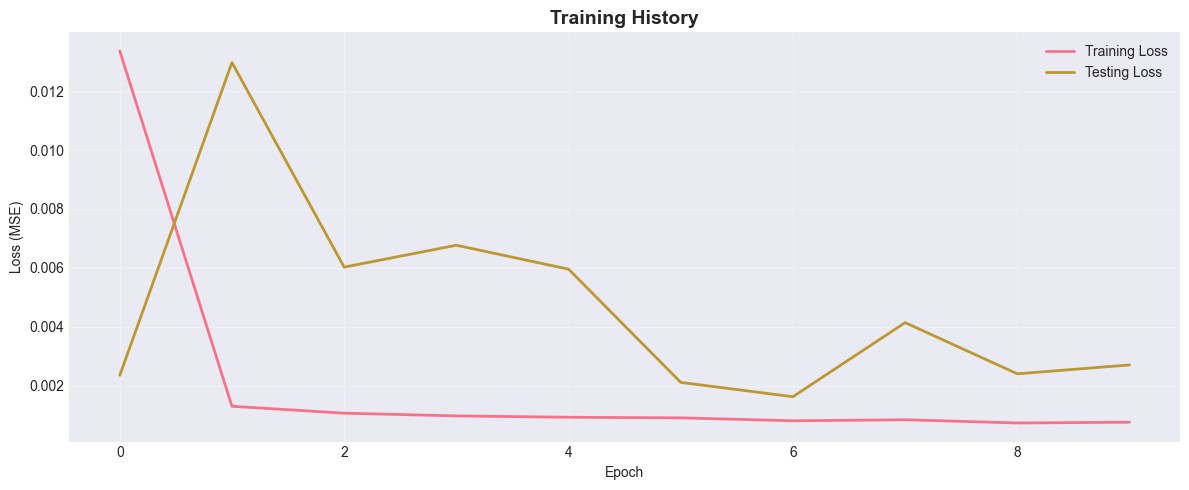

In [ ]:
# ==========================================
# 5. TRAINING MODEL
# ==========================================
print("\n[5] Melatih model...")

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5, verbose=False)

num_epochs = 10
train_losses = []
test_losses = []

best_test_loss = float('inf')

# Progress bar untuk epoch
epoch_bar = tqdm(range(num_epochs), desc='Training Progress', ncols=100)

for epoch in epoch_bar:
    # Training
    model.train()
    train_loss = 0

    # Progress bar untuk batch training
    train_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]',
                     leave=False, ncols=100)

    for X_batch, y_batch in train_bar:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        # Update progress bar dengan loss
        train_bar.set_postfix({'loss': f'{loss.item():.6f}'})

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Testing
    model.eval()
    test_loss = 0

    # Progress bar untuk batch testing
    test_bar = tqdm(test_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Test]',
                    leave=False, ncols=100)

    with torch.no_grad():
        for X_batch, y_batch in test_bar:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            test_loss += loss.item()

            # Update progress bar dengan loss
            test_bar.set_postfix({'loss': f'{loss.item():.6f}'})

    test_loss /= len(test_loader)
    test_losses.append(test_loss)

    # Learning rate scheduler
    scheduler.step(test_loss)

    # Save best model
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        torch.save(model.state_dict(), 'best_lstm_model.pth')
        best_epoch = epoch + 1

    # Update epoch progress bar
    epoch_bar.set_postfix({
        'Train Loss': f'{train_loss:.6f}',
        'Test Loss': f'{test_loss:.6f}',
        'Best': f'{best_test_loss:.6f}'
    })

print(f"\n✓ Training selesai!")
print(f"  Best Test Loss: {best_test_loss:.6f} (Epoch {best_epoch})")

# Load best model
model.load_state_dict(torch.load('best_lstm_model.pth'))

# Plot training history
plt.figure(figsize=(12, 5))
plt.plot(train_losses, label='Training Loss', linewidth=2)
plt.plot(test_losses, label='Testing Loss', linewidth=2)
plt.title('Training History', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
print("✓ Grafik training history disimpan sebagai 'training_history.png'")

In [ ]:
# ==========================================
# 6. PREDIKSI & VISUALISASI
# =====================================

print("\n[6] Membuat prediksi 180 hari ke depan...")

model.eval()

# Prediksi pada test set
test_predictions = []
with torch.no_grad():
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        pred = model(X_batch)
        test_predictions.extend(pred.cpu().numpy())

test_predictions = np.array(test_predictions)

# Prediksi 180 hari ke depan
future_days = 180
last_sequence = scaled_data[-sequence_length:].reshape(1, sequence_length, 1)
future_predictions = []

with torch.no_grad():
    current_sequence = torch.FloatTensor(last_sequence).to(device)

    for _ in range(future_days):
        # Prediksi hari berikutnya
        pred = model(current_sequence)
        future_predictions.append(pred.cpu().numpy()[0, 0])

        # Update sequence
        pred_reshaped = pred.view(1, 1, 1)
        current_sequence = torch.cat([current_sequence[:, 1:, :], pred_reshaped], dim=1)

future_predictions = np.array(future_predictions).reshape(-1, 1)

# Inverse transform
test_predictions_actual = scaler.inverse_transform(test_predictions)
y_test_actual = scaler.inverse_transform(y_test)
future_predictions_actual = scaler.inverse_transform(future_predictions)

# Buat tanggal untuk prediksi masa depan
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=future_days, freq='D')



[6] Membuat prediksi 180 hari ke depan...


✓ Grafik prediksi final disimpan sebagai 'bbca_prediction_final.png'

RINGKASAN HASIL PREDIKSI

Performa Model pada Test Set:
  • RMSE  : IDR 421.37
  • MAE   : IDR 338.27
  • MAPE  : 3.87%

Prediksi Harga:
  • Harga saat ini (terakhir): IDR 8,000
  • Prediksi 30 hari  : IDR 7,436
  • Prediksi 90 hari  : IDR 7,103
  • Prediksi 180 hari : IDR 7,030

Perubahan Prediksi:
  • 30 hari  : -7.04%
  • 90 hari  : -11.21%
  • 180 hari : -12.13%

Project selesai! Model dan grafik telah disimpan.


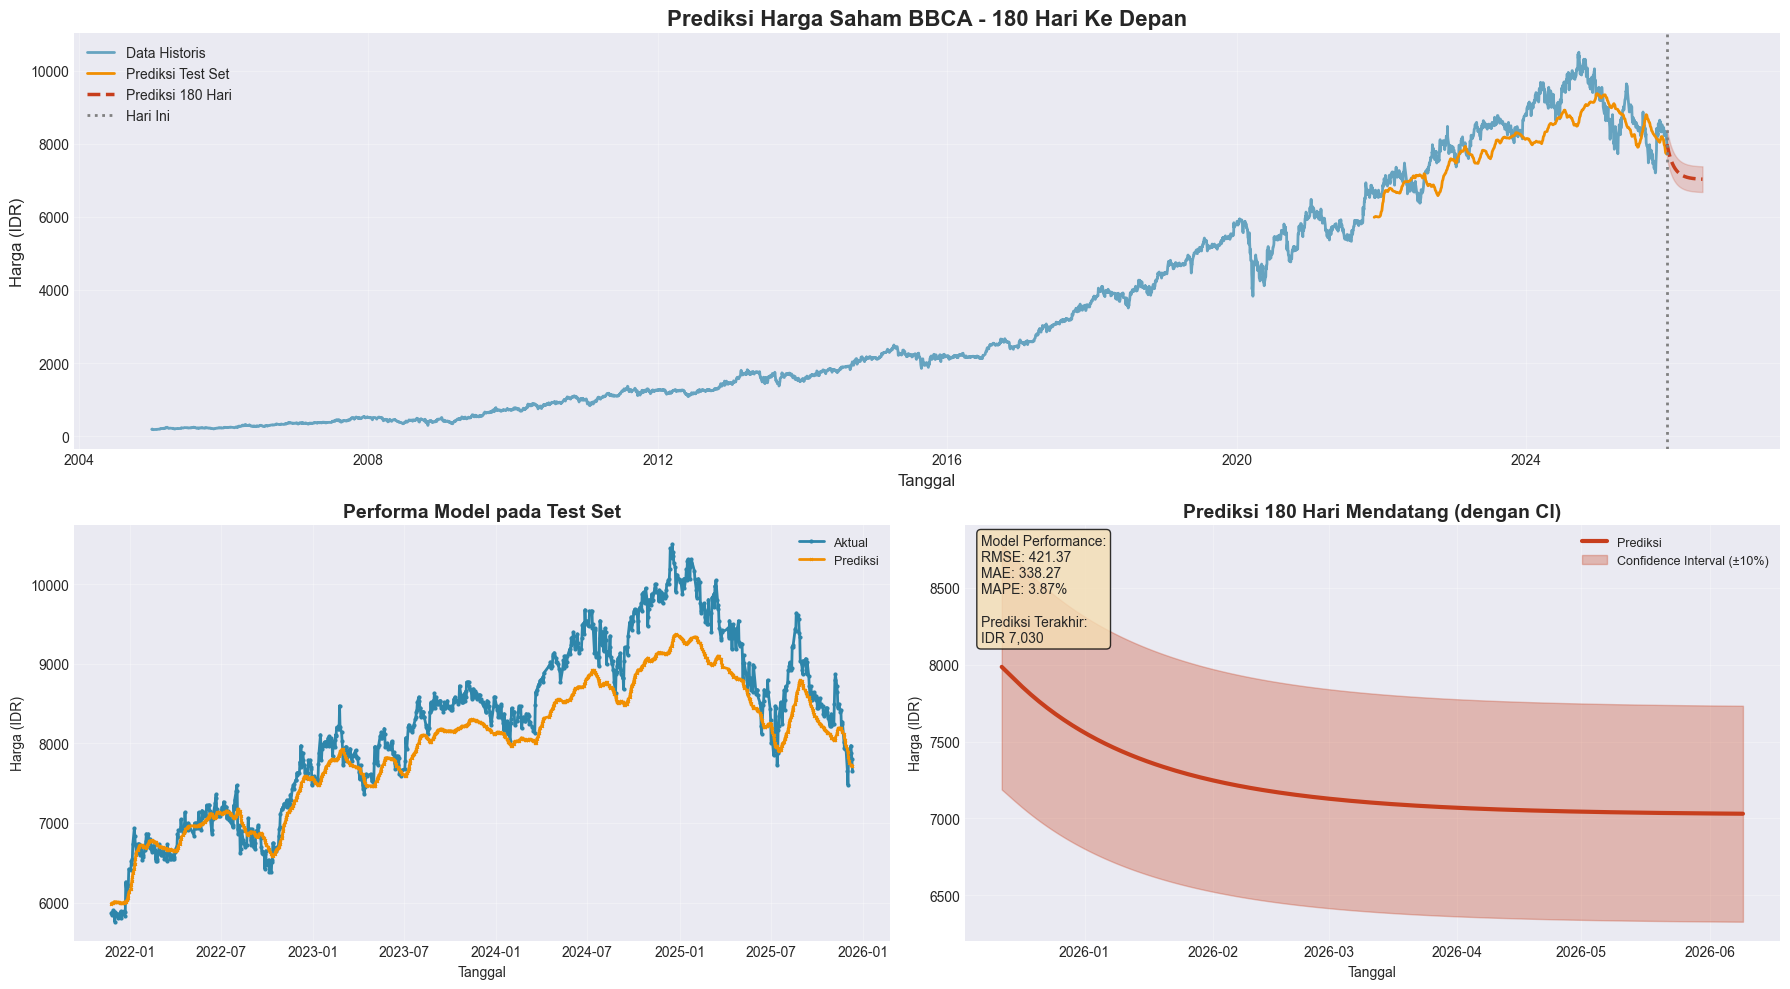

In [ ]:
# ==========================================
# VISUALISASI FINAL YANG MENARIK
# ==========================================
# =====================================
# FIX: Samakan panjang tanggal & prediksi
# =====================================
# Rekonstruksi test_dates dari index
test_dates = df.index[train_size + sequence_length: train_size + sequence_length + len(test_predictions_actual)]

# Sesuaikan panjang jika perlu
min_len = min(len(test_dates), len(test_predictions_actual), len(y_test_actual))
test_dates = test_dates[:min_len]
test_predictions_actual = test_predictions_actual[:min_len]
y_test_actual = y_test_actual[:min_len]

fig = plt.figure(figsize=(18, 10))

# Plot 1: Overview prediksi (Full history + prediction)
ax1 = plt.subplot(2, 2, (1, 2))
plt.plot(df.index, df['Close'], label='Data Historis', linewidth=2, color='#2E86AB', alpha=0.7)
test_dates = df.index[train_size + sequence_length:]
plt.plot(test_dates, test_predictions_actual, label='Prediksi Test Set', linewidth=2, color='#F18F01')
plt.plot(future_dates, future_predictions_actual, label='Prediksi 180 Hari', linewidth=2.5, color='#C73E1D', linestyle='--')
plt.axvline(x=last_date, color='gray', linestyle=':', linewidth=2, label='Hari Ini')
plt.fill_between(future_dates, future_predictions_actual.flatten() * 0.95,
                 future_predictions_actual.flatten() * 1.05, alpha=0.2, color='#C73E1D')
plt.title('Prediksi Harga Saham BBCA - 180 Hari Ke Depan', fontsize=16, fontweight='bold')
plt.xlabel('Tanggal', fontsize=12)
plt.ylabel('Harga (IDR)', fontsize=12)
plt.legend(fontsize=10, loc='upper left')
plt.grid(True, alpha=0.3)

# Plot 2: Zoom pada test set
ax2 = plt.subplot(2, 2, 3)
plt.plot(test_dates, y_test_actual, label='Aktual', linewidth=2, marker='o', markersize=2, color='#2E86AB')
plt.plot(test_dates, test_predictions_actual, label='Prediksi', linewidth=2, marker='x', markersize=2, color='#F18F01')
plt.title('Performa Model pada Test Set', fontsize=14, fontweight='bold')
plt.xlabel('Tanggal', fontsize=10)
plt.ylabel('Harga (IDR)', fontsize=10)
plt.legend(fontsize=9)
plt.grid(True, alpha=0.3)

# Hitung metrik
mse = np.mean((y_test_actual - test_predictions_actual) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_test_actual - test_predictions_actual))
mape = np.mean(np.abs((y_test_actual - test_predictions_actual) / y_test_actual)) * 100

# Plot 3: Prediksi 180 hari dengan confidence interval
ax3 = plt.subplot(2, 2, 4)
plt.plot(future_dates, future_predictions_actual, linewidth=3, color='#C73E1D', label='Prediksi')
plt.fill_between(future_dates,
                 future_predictions_actual.flatten() * 0.90,
                 future_predictions_actual.flatten() * 1.10,
                 alpha=0.3, color='#C73E1D', label='Confidence Interval (±10%)')
plt.title('Prediksi 180 Hari Mendatang (dengan CI)', fontsize=14, fontweight='bold')
plt.xlabel('Tanggal', fontsize=10)
plt.ylabel('Harga (IDR)', fontsize=10)
plt.legend(fontsize=9)
plt.grid(True, alpha=0.3)

# Tambahkan text box dengan metrik
textstr = f'Model Performance:\n' \
          f'RMSE: {rmse:.2f}\n' \
          f'MAE: {mae:.2f}\n' \
          f'MAPE: {mape:.2f}%\n\n' \
          f'Prediksi Terakhir:\n' \
          f'IDR {future_predictions_actual[-1][0]:,.0f}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
ax3.text(0.02, 0.98, textstr, transform=ax3.transAxes, fontsize=10,
         verticalalignment='top', bbox=props)

plt.tight_layout()
plt.savefig('bbca_prediction_final.png', dpi=300, bbox_inches='tight')
print("✓ Grafik prediksi final disimpan sebagai 'bbca_prediction_final.png'")

# ==========================================
# RINGKASAN HASIL
# ==========================================
print("\n" + "=" * 60)
print("RINGKASAN HASIL PREDIKSI")
print("=" * 60)
print(f"\nPerforma Model pada Test Set:")
print(f"  • RMSE  : IDR {rmse:,.2f}")
print(f"  • MAE   : IDR {mae:,.2f}")
print(f"  • MAPE  : {mape:.2f}%")
print(f"\nPrediksi Harga:")
print(f"  • Harga saat ini (terakhir): IDR {df['Close'].iloc[-1]:,.0f}")
print(f"  • Prediksi 30 hari  : IDR {future_predictions_actual[29][0]:,.0f}")
print(f"  • Prediksi 90 hari  : IDR {future_predictions_actual[89][0]:,.0f}")
print(f"  • Prediksi 180 hari : IDR {future_predictions_actual[179][0]:,.0f}")
print(f"\nPerubahan Prediksi:")
change_30 = ((future_predictions_actual[29][0] - df['Close'].iloc[-1]) / df['Close'].iloc[-1]) * 100
change_90 = ((future_predictions_actual[89][0] - df['Close'].iloc[-1]) / df['Close'].iloc[-1]) * 100
change_180 = ((future_predictions_actual[179][0] - df['Close'].iloc[-1]) / df['Close'].iloc[-1]) * 100
print(f"  • 30 hari  : {change_30:+.2f}%")
print(f"  • 90 hari  : {change_90:+.2f}%")
print(f"  • 180 hari : {change_180:+.2f}%")
print("\n" + "=" * 60)
print("Project selesai! Model dan grafik telah disimpan.")
print("=" * 60)